# Ensemble Models Demystified (with Python)

In [1]:
from IPython.display import Image  
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# My helpers -- check the github repo
from helpers import get_tree_as_image, plot_gb_mae, plot_rf_mae, plot_n_predictions_rf, plot_residuals_gb

## 1. Find some data

Data from many posts on Facebook pages.

Download: https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

Features include:
- Page category
- Total number of comments on the page
- Number of comments on the page in last 24h
- etc...

The target (column 54) is the number of comments the post will receive in the next hour.

In [2]:
import pandas as pd

df = pd.read_csv("Dataset/Training/Features_Variant_1.csv", 
                 header=None,
                 names=["X" + str(i) for i in range(1, 55)])

df.sample(n=10)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54
8940,155266,1284,2454,60,0.0,16.0,1.357143,0.0,2.346567,0.0,...,0,0,0,0,0,0,0,1,0,0
40549,1426027,0,8025,1,0.0,214.0,9.719008,3.0,29.129016,0.0,...,0,0,0,0,0,1,0,0,0,0
6424,952756,8,443107,9,0.0,791.0,83.666667,22.5,158.853357,0.0,...,0,0,0,0,0,0,0,1,0,0
21482,228007,0,24,16,0.0,304.0,12.323529,2.0,37.684425,0.0,...,1,0,0,0,0,0,0,0,1,0
37227,30366,306,2,17,0.0,15.0,1.638889,1.0,2.750281,0.0,...,1,0,1,0,0,0,0,0,0,0
9598,114303,0,41419,24,0.0,1239.0,82.384615,51.0,159.052066,0.0,...,0,1,1,0,0,0,0,0,0,42
32634,274207,0,100435,18,2.0,664.0,134.565854,74.0,136.996428,0.0,...,0,0,0,0,1,0,0,0,0,2
24001,433536,615,11192,24,0.0,109.0,27.350000,11.0,29.592018,0.0,...,1,0,0,0,0,0,0,1,0,2
16036,590707,0,25344,79,0.0,213.0,34.481013,24.0,35.069140,0.0,...,0,0,0,0,0,0,0,1,0,0
1792,115669,0,745,1,0.0,26.0,1.691892,0.0,3.831193,0.0,...,0,0,0,1,0,0,0,0,0,1


In [3]:
df.shape

(40949, 54)

Get features and target

In [4]:
X = df.iloc[:,:53]
y = df.iloc[:,53]

Split dataset into training & testing set

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## 2. Weak learners -  Decision Trees

* Can capture complex relationship in the data [can get good enough accuracy]
* Overfits easily [good to create different models]

In [6]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=2)

In [7]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

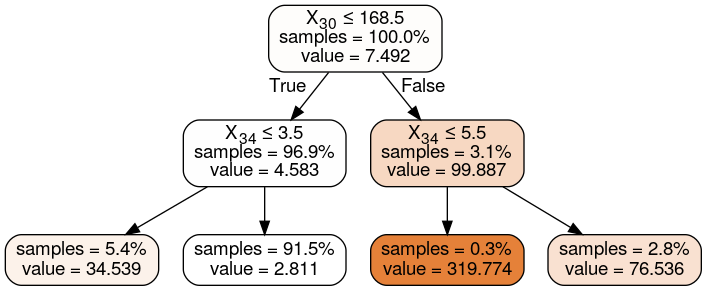

In [8]:
Image(get_tree_as_image(dt))

In [9]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(dt.predict(X_test), y_test)

7.7940505537044915

Good, but that a really simplistic model. In practice we might want to add more complexity to capture more complex relationships in the data than three binary rules. Let's increase the depth of our tree!

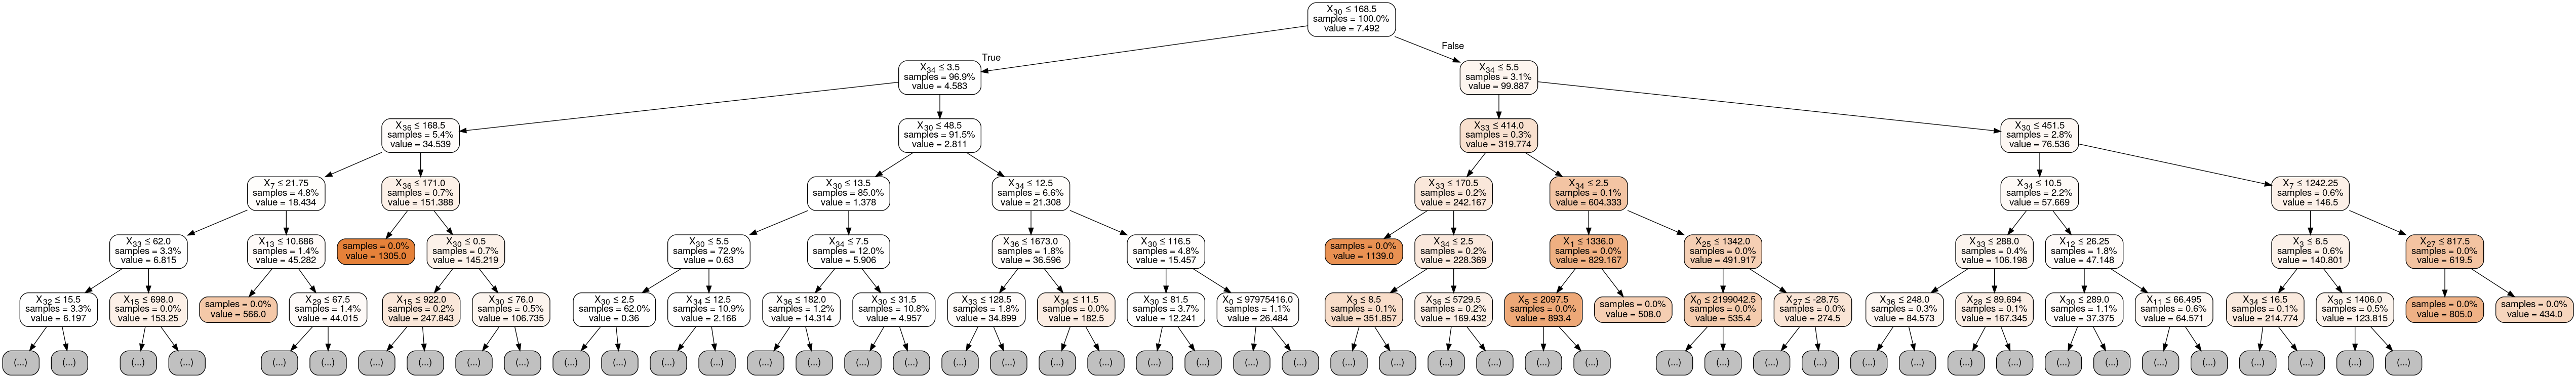

In [10]:
dt = DecisionTreeRegressor(max_depth=12)
dt.fit(X_train, y_train)
Image(get_tree_as_image(dt))

In [11]:
mean_absolute_error(dt.predict(X_test), y_test)

5.240679939662471

MAE has decreased a little. But if we look at the plot, we see that some nodes are only representative of a few data points (0.0% of the data). 

That seems like overfitting to noise, how can we prevent that without reducing our max depth? 

Here comes `min_sample_split`, the minimum number of samples required to make a split.

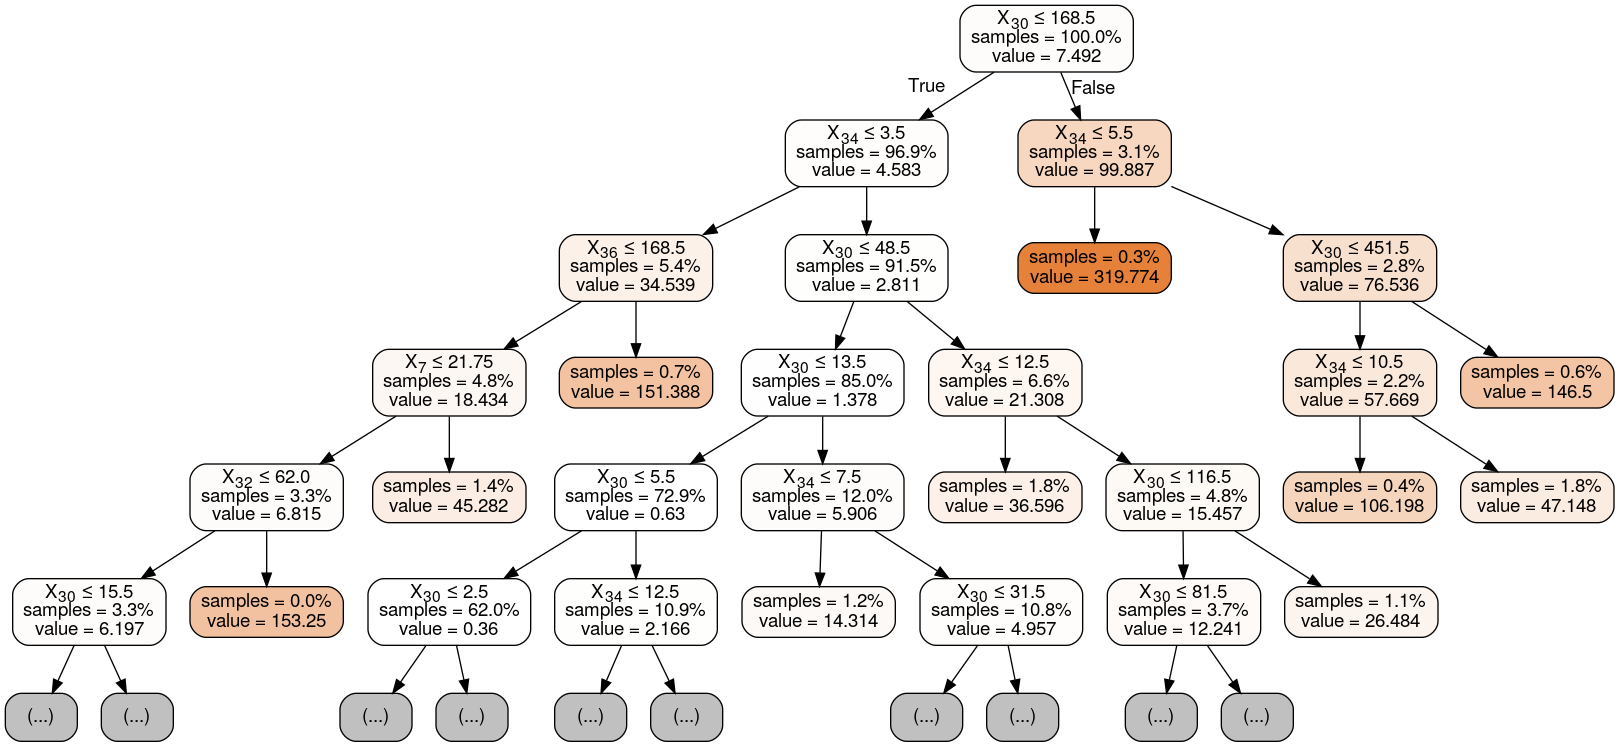

In [12]:
dt = DecisionTreeRegressor(max_depth=12, min_samples_split=.02)
dt.fit(X_train, y_train)
Image(get_tree_as_image(dt))

In [13]:
mean_absolute_error(dt.predict(X_test), y_test)

5.009432832264435

This tree seems to better generalise!

## 3. Bagging - Random Forest

![](img/bagging-diagram.png)

In order to build diverse trees we can:
- Train each on a subsample of observations (bootstrap)
- Train each on a subsample of features
- Loosely constrain trees to let them overfit (but not too much)

In [14]:
from sklearn.ensemble import RandomForestRegressor

Let's start with 15 trees, without using the boostrap and feature sampling techniques and keeping the trees well constrained.

In [15]:
rf = RandomForestRegressor(
    # Tree parameters
    max_depth=5, min_samples_split=.1,

    # Ensemble parameters
    n_estimators=15, max_features=None, bootstrap=False,

    # Misc
    random_state=42, n_jobs=-1)

In [16]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.1,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [17]:
y_pred = rf.predict(X_test)

Check MAE

In [18]:
mean_absolute_error(y_pred, y_test)

6.418274082768221

Look at estimators individually

In [19]:
rf.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1608637542, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1273642419, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1935803228, splitter='best'),
 DecisionTreeRegressor(crite

In [20]:
# Get the first tree
tree = rf.estimators_[0]

In [21]:
mean_absolute_error(tree.predict(X_test), y_test)

6.418274082768221

Check MAE of each single tree

In [22]:
[mean_absolute_error(tree.predict(X_test), y_test) for tree in rf.estimators_]

[6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221,
 6.418274082768221]

Let's plot it

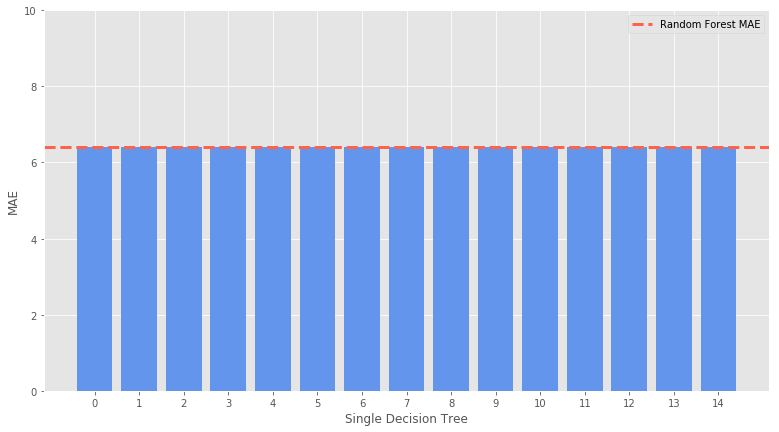

In [23]:
plot_rf_mae(rf, X_test, y_test)

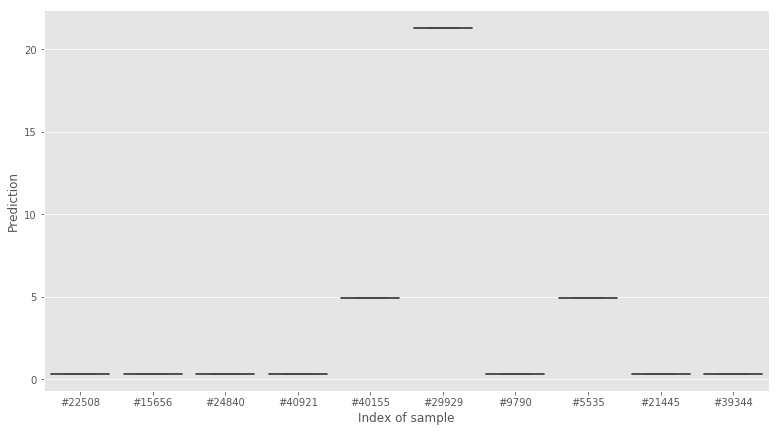

In [24]:
plot_n_predictions_rf(rf, X_test)

All trees have the exact same MAE. Our ensemble isn't better than a single tree. Let's try again by adding both boostrap and feature sampling.

In [25]:
rf = RandomForestRegressor(
    # Tree parameters
    max_depth=5, min_samples_split=.1,
    
    # Ensemble parameters
    n_estimators=15, max_features="auto", bootstrap=True,

    # Misc
    random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_pred, y_test)

6.120134164784247

Check MAE of the single trees

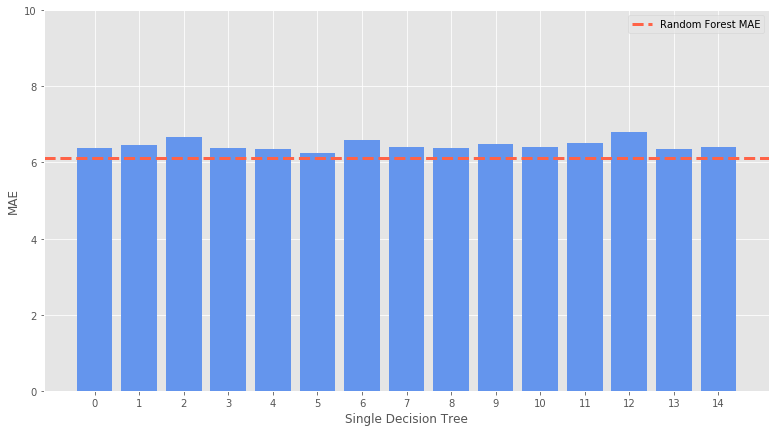

In [26]:
plot_rf_mae(rf, X_test, y_test)

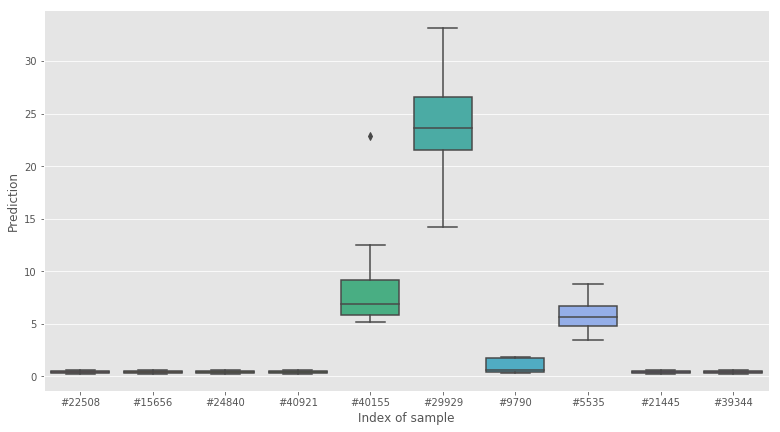

In [27]:
plot_n_predictions_rf(rf, X_test)

Finally let's make our trees overfit more easily by increasing `max_depth` and decreasing the `min_sample_split` constraint.

In [28]:
rf = RandomForestRegressor(
    # Tree parameters
    max_depth=15, min_samples_split=.001,
    
    # Ensemble parameters
    n_estimators=15, max_features="auto", bootstrap=True,

    # Misc
    random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.050547131322777

Again, check accuracy on individual trees

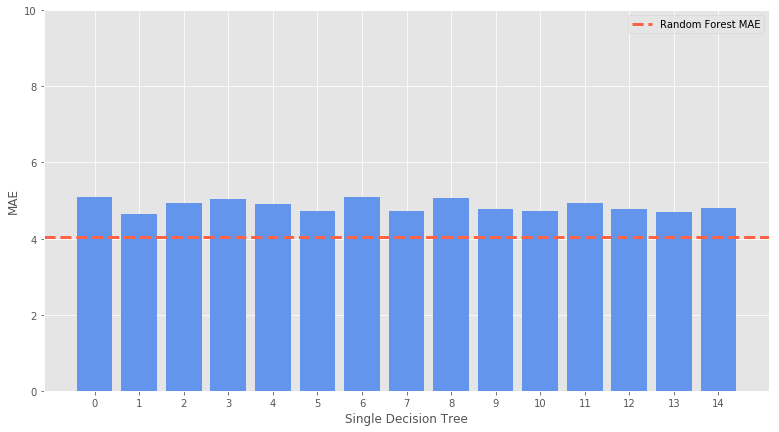

In [29]:
plot_rf_mae(rf, X_test, y_test)

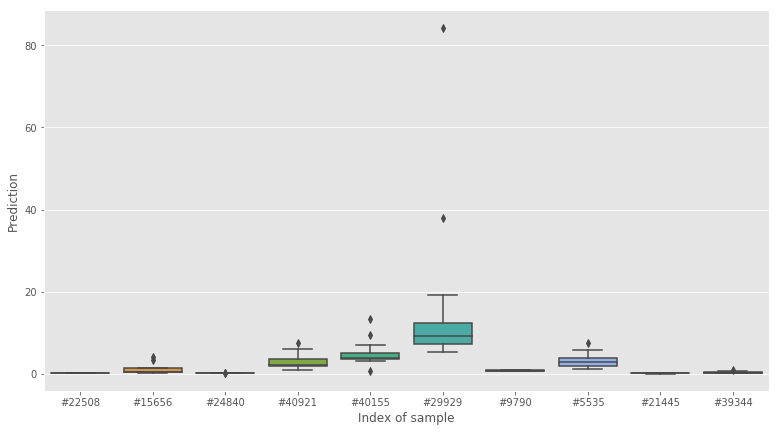

In [30]:
plot_n_predictions_rf(rf, X_test)

In [31]:
rf.estimators_[0].feature_importances_

array([1.81145366e-03, 1.01044171e-02, 2.50258861e-03, 4.66751157e-03,
       8.58752878e-06, 4.62505813e-05, 1.46682520e-05, 5.77999546e-04,
       2.18283612e-03, 0.00000000e+00, 1.18866441e-04, 3.83100341e-03,
       1.16427669e-02, 2.36834639e-02, 0.00000000e+00, 5.45673668e-04,
       1.58425004e-02, 1.99867045e-03, 6.45087666e-05, 7.17141175e-06,
       2.07111123e-04, 1.74012350e-04, 1.60354651e-03, 1.27538957e-04,
       1.86100638e-03, 1.15982248e-05, 5.72020499e-04, 2.45719261e-02,
       2.26757534e-05, 8.22885167e-03, 3.35672462e-01, 1.65018199e-05,
       4.90481469e-03, 6.70132684e-02, 2.42259853e-01, 9.97000506e-04,
       2.29673549e-01, 0.00000000e+00, 5.61767376e-06, 2.12502640e-05,
       0.00000000e+00, 1.72176694e-05, 8.32972995e-05, 2.43884007e-06,
       2.30746802e-06, 1.45551502e-03, 1.74339388e-04, 1.24880923e-05,
       1.58827279e-05, 3.41918362e-06, 6.06200745e-04, 8.21723877e-07,
       3.05280617e-05])

## 4. Boosting - Gradient Boosting

![](img/boost-diagram.png)

Here we build trees sequentially. Each new tree is trained to correct the errors of the previous ones. From the second tree, we use the residuals (difference between predicted value and actual one) as new target.

With two many stages, it can overfit to noise
- Need to keep small, constrained trees
- Need to make sure we don't have too many stages

Can also keep the trees different to benefit from the ensemble advantage. We can use `subsample` and `max_features` for that.

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=12, min_samples_split=.05,
    
    # Ensemble parameters
    n_estimators=5, subsample=.8, max_features="auto", learning_rate=.5,
 
    # Misc.
    random_state=42)

In [34]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=12,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=0.05,
             min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
             random_state=42, subsample=0.8, verbose=0, warm_start=False)

In [35]:
y_pred = gb.predict(X_test)

Check overall MAE

In [36]:
mean_absolute_error(y_pred, y_test)

5.123788858955904

Here the MAE of a single tree does not make sense since each new tree is correcting the error of the previous ones. But in `sklearn` we can get the MAE at given stage, including all trees from the previous stages.

In [37]:
[mean_absolute_error(y_pred, y_test) for y_pred in gb.staged_predict(X_test)]

[7.667186671362484,
 6.259327833636609,
 5.789045357355478,
 5.53595615940551,
 5.123788858955904]

Let's visualise it

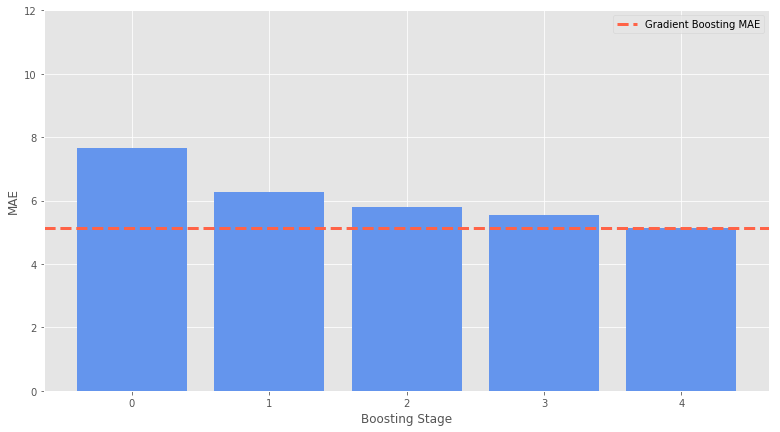

In [38]:
plot_gb_mae(gb, X_test, y_test)

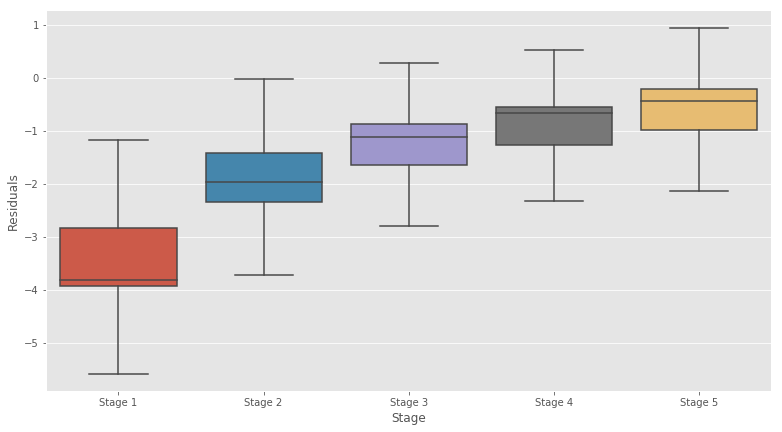

In [39]:
plot_residuals_gb(gb, X_train, y_train, step_size=1)

MAE is decreasing with each new tree that we add. Maybe we're underfitting and could still get better by adding more trees? Let's try it.

In [40]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=12, min_samples_split=.05,
    
    # Ensemble parameters
    n_estimators=20, subsample=.8, max_features="auto", learning_rate=.5,
 
    # Misc.
    random_state=42)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.8952094730085385

Overall MAE is better, let's check the MAE at every stage.

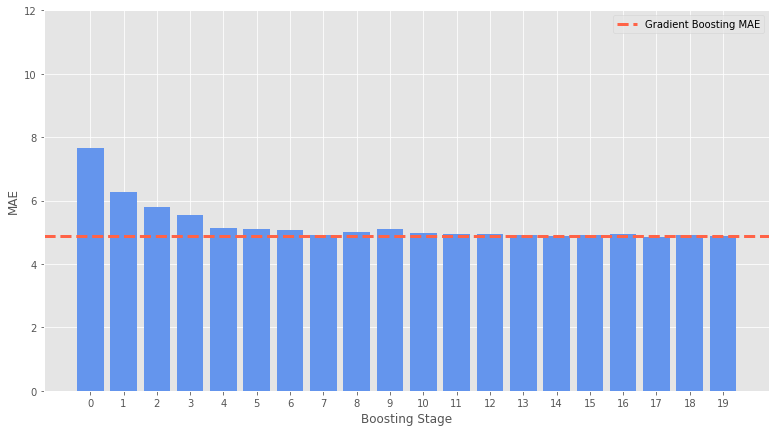

In [41]:
plot_gb_mae(gb, X_test, y_test)

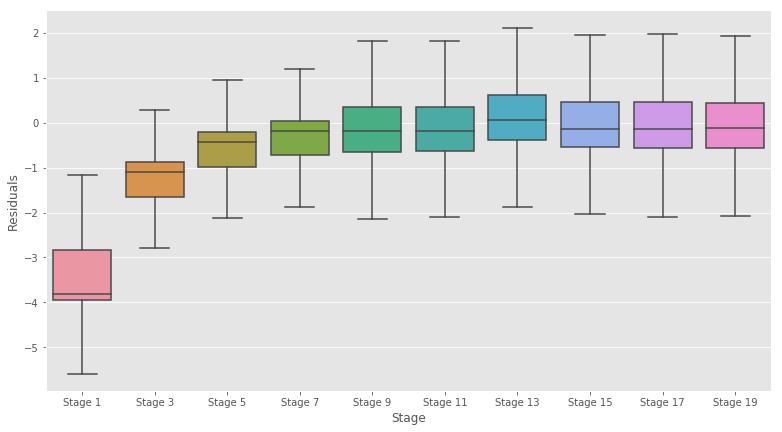

In [42]:
plot_residuals_gb(gb, X_train, y_train, step_size=2)

Here adding more trees doesn't seem to help after a few stages and the MAE starts to converge quickly. We need to loosen the constraints on our trees so they get more complex.

Let's see what happens if we loosen the constraints a lot and let our trees overfit

In [43]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=12, min_samples_split=.001,
    
    # Ensemble parameters
    n_estimators=20, subsample=.8, max_features="auto", learning_rate=.5,
 
    # Misc.
    random_state=42)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.917075123026421

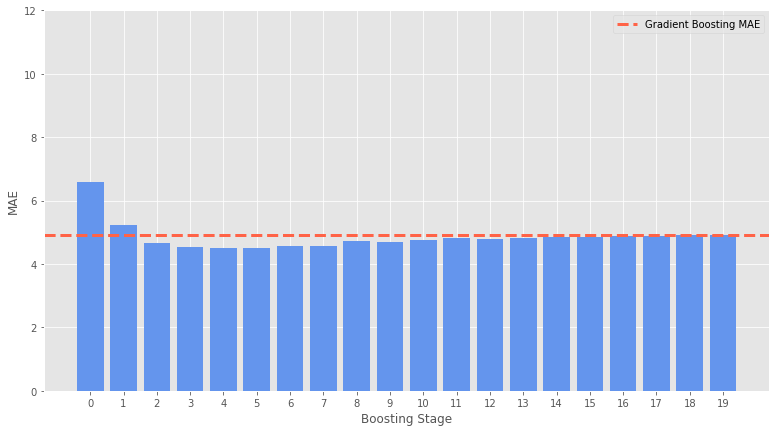

In [44]:
plot_gb_mae(gb, X_test, y_test)

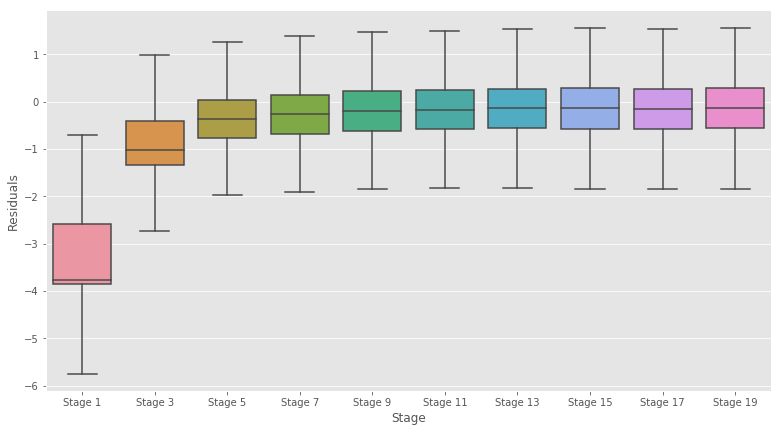

In [45]:
plot_residuals_gb(gb, X_train, y_train, step_size=2)

MAE went down and starting going up again after some stages. Our model started overfitting. We can decrease the number of trees, learning rate or add more constrains on our weak learners.

Now we'll decrease the learning rate, so we can build more trees without overfitting (regularisation). Additionally we make the constraint harder on max_depth

In [46]:
gb = GradientBoostingRegressor(
    # Keep trees well constrained
    max_depth=8, min_samples_split=.005,
    
    # Ensemble parameters
    n_estimators=30, subsample=.8, max_features="auto", learning_rate=.1,
 
    # Misc.
    random_state=42)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_absolute_error(y_pred, y_test)

4.210291108821273

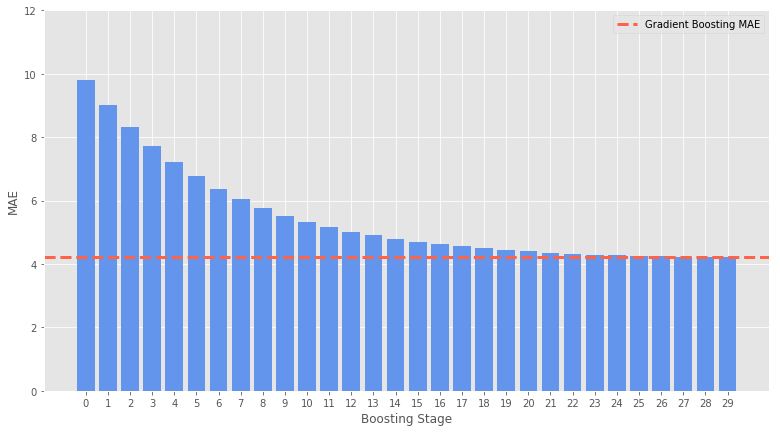

In [47]:
plot_gb_mae(gb, X_test, y_test)

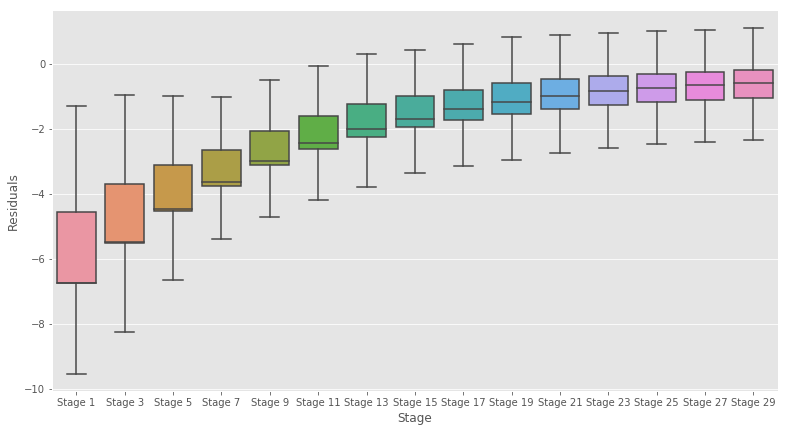

In [48]:
plot_residuals_gb(gb, X_train, y_train, step_size=2)

The sklearn implementation of gradient boosting cannot be run in parallel, hence it can be quite slow when many trees have to be trained. Several popular libraries implement optimised version of gradient boosting and can run in parallel, such as `xgboost`, `lightgbm` and `catboost`.

## 5. Other boosting libraries - XGBoost, LightGBM, CatBoost

In [49]:
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [50]:
xgb = XGBRegressor(n_estimators=40, max_depth=8, min_samples_split=.005, n_jobs=-1)
xgb.fit(X_train, y_train)
mean_absolute_error(xgb.predict(X_test), y_test)

3.908602742169706

In [51]:
lgb = LGBMRegressor(n_estimators=40, max_depth=8, min_samples_split=.005, n_jobs=-1)
lgb.fit(X_train, y_train)
mean_absolute_error(lgb.predict(X_test), y_test)

4.071846028113166

In [52]:
ctb = CatBoostRegressor(n_estimators=60, max_depth=8)
ctb.fit(X_train, y_train)
mean_absolute_error(ctb.predict(X_test), y_test)

0:	learn: 37.1236756	total: 151ms	remaining: 8.88s
1:	learn: 36.5662551	total: 207ms	remaining: 6.01s
2:	learn: 36.0340336	total: 266ms	remaining: 5.05s
3:	learn: 35.5454192	total: 325ms	remaining: 4.55s
4:	learn: 35.0057902	total: 401ms	remaining: 4.41s
5:	learn: 34.5189873	total: 460ms	remaining: 4.14s
6:	learn: 34.0358753	total: 516ms	remaining: 3.91s
7:	learn: 33.5799149	total: 579ms	remaining: 3.77s
8:	learn: 33.1525292	total: 650ms	remaining: 3.68s
9:	learn: 32.7053296	total: 708ms	remaining: 3.54s
10:	learn: 32.3071744	total: 767ms	remaining: 3.42s
11:	learn: 31.8946439	total: 829ms	remaining: 3.32s
12:	learn: 31.5008010	total: 906ms	remaining: 3.27s
13:	learn: 31.1261239	total: 971ms	remaining: 3.19s
14:	learn: 30.8087719	total: 1.03s	remaining: 3.1s
15:	learn: 30.4892595	total: 1.12s	remaining: 3.07s
16:	learn: 30.1356828	total: 1.19s	remaining: 3s
17:	learn: 29.8040841	total: 1.28s	remaining: 2.99s
18:	learn: 29.4985165	total: 1.38s	remaining: 2.98s
19:	learn: 29.1808843	tota

4.022765038455377